# Pairs Trading Strategy Design & Backtest

The definition of Pairs Trading is to take advantage of the mispricing between two or more assets by taking long and short portfolio, betting the related movement will converge back when mispricing situation happening. The principle is buying undervalued and selling overvalued. This is a very charming strategy that we can extend the idea in any market of interest. 

The first pairs trading bears its roots in equity market, but we can possibly extend the idea into commodities, cryptos, and even options market.

### Import required libraries

In [2]:
import warnings
import numpy as np
import pandas as pd
import datetime as dt
import statsmodels.api as sm
from statsmodels.tsa.api import adfuller
import matplotlib.pyplot as plt
import pyfolio as pf
import yfinance as yf
from scipy import optimize
from scipy.stats import norm
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")
plt.style.use('seaborn')

# Pairs Trading Tutourial
## Signal Generation and Backtesting
- Be inventive beyond equity pairs: consider commodity futures, instruments on interest rates, and aggregated indices.
- Arb is relized by using cointegrating $\beta_{Coint}$ as allocation weight. All project designs should including trading signal generation(OU process fitting) and backtesting.
- Does P&L behave as expected for cointegration arb trade? Is P&L coming from a few or many trades, what is half-life? Maximum Drawdown and behaviour of volatility/VaR?
- Introduce liquidity and algorithmic flow considerations (a model of order flow). Any rules on accumulating the position? What impact bid-ask spread and transaction costs will make?
## Step-by-step instructions
- Part I: pairs trading design
    - re-code regression estimation in martrix form - your own OLS implementation which you can re-use. Regression between stationary variables(DF test regression/difference equation) has optional model specification test for (a)identifying optimal lag p with AIC BIC tests and (b) stability check
    - Implement Engle-Granger procedure for each pair. Step1 use ADF test for unit root with lag1. Step2, formulate both correction equation and decide which one is more important
    - Decide signals: $\mu_e\pm Z\sigma_{eq}$ and exit on $\mu_t$
    - At first aussme Z=1. Then change Z sightly upwards and downwards - compute P&L for each case of bounds. Alternatively run an optimization that varies Z and maxmize the P&L or other criterion.
    - Optionally us VECM in order select the best candidate for pairs trading (or basket trading).
    
- Part II: Backtesting
    - perform systematic backtesting of your trading strategy platform to produce drawdown plots, rolling Sharpe ratio and rolling beta
    - keep delivering staionary spread over 3-6 months. Kalman filter will give updated beta. However, you can simply re-estmate cointergration by shifting data 1-2 weeks and report beta and EG.
    - use Machine-learning-inspired backtesting, such as spliting data, time series CV.
    
   

# Part I: Pairs Trading Design
## 1.1 Data Processing
One study by Jacob & Weber conducted several international markets which has empirically proven that the pairs trading works the most in emerging market, either from the high ineffciencies or a large number of available pairs. So I believe some innovative market has more opportunities than equity market.

In this case, I want to study model-driven statistical arbitrage strategies in commodities and crypto market. The crpyto is the youngest and has less research than other assets, which becomes very attractive for pairs trading strategy design. From those three different perspectives, we can identify multiple strategy implementations and more profitable opportunities. So, in the first step, we sort out a list of available symbols and prepare them for filtering.

In [3]:
## In this case, I want to implement pairs trading from two perspectives - equity and commodity market.
## First I listed some potentially profitable tickers to be tested from different market.
start = '2005-01-01'
end = '2022-07-30'
tickers_commodity = {'Gold':'GC=F',
                     'Sliver':'SI=F',
                     'Crude Oil':'CL=F',
                     'Natural Gas':'NG=F',
                     'Gasoline':'RB=F',
                     'E-Mini S&P 500':'ES=F'}

tickers_crypto = ['BTC-USD','ETH-USD','ADA-USD','SOL-USD','BNB-USD','DOGE-USD','LTC-USD']

tickers_stock = ['']
price_commodity = yf.download(list(tickers_commodity.values()), start, end)['Adj Close'].dropna()
price_commodity.rename({v:k for k,v in tickers_commodity.items()},axis=1,inplace=True)

price_crypto = yf.download(tickers_crypto, '2017-12-01', end)['Adj Close'].dropna()['2021-07':]
price_crypto.head()

[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  7 of 7 completed


,ADA-USD,BNB-USD,BTC-USD,DOGE-USD,ETH-USD,LTC-USD,SOL-USD
Date,,,,,,,
2021-07-01,1.335611,288.218414,33572.117188,0.244549,2113.605469,137.577530,33.404034
2021-07-02,1.394397,287.423096,33897.046875,0.245264,2150.040283,136.943695,34.020481
2021-07-03,1.406836,298.237122,34668.546875,0.246411,2226.114258,140.279694,34.478817
2021-07-04,1.458184,307.732086,35287.781250,0.246483,2321.724121,144.905853,34.310600
2021-07-05,1.404898,302.377991,33746.003906,0.231614,2198.582520,138.073242,32.984589


In [4]:
price_commodity.head()

,Crude Oil,E-Mini S&P 500,Gold,Natural Gas,Gasoline,Sliver
Date,,,,,,
2005-01-03,42.119999,1206.25,428.700012,5.790,1.1317,6.477
2005-01-04,43.910000,1191.00,428.500000,5.902,1.1721,6.427
2005-01-05,43.389999,1183.25,426.600006,5.833,1.1710,6.512
2005-01-06,45.560001,1188.25,421.000000,6.049,1.2229,6.433
2005-01-07,45.430000,1186.25,418.899994,6.001,1.2142,6.429


## 1.2 Cointegration Apporach
Cointegration: I(d) series, which means integrated series of order d
I(1) series: Price
I(0) series: Returns
The prices of cointegrated assets fluctuate around a certain average level. So cointegration allows us to construct a 2-asset portfolio with stationary series to be traded. Then we are able to construct a mean-reversion strategy.

### Find $\beta_{Coint}$
- Engle-Grange test
    - Linear regression on the candidate pairs price and calculate its residual
    - Test the stationary of the residual
- Johansen test
    - VECM
    
    
We have two apporaches to find cointegration beta parameter. 
### Engle-Grange
The first idea of the Engle-Granger test is to perform a linear regression between two underlying assets and test its residual, and see if the series is stationary by applying the Augmented Dick-Fuller test. So if the residual is a stationary series, we can say the two prices are cointegrated. The $\beta_{Coint}$ is obtained as the asset weight to be traded.


In the stationarity test, we test for a unit root, which is based on the following hypothesis test:
$$H_0: \phi =1 \rightarrow y_t \sim I(0) | (unit root)$$
$$H_1:\mid\phi\mid <1 \rightarrow y_t \sim I(0) | (stationary)$$

### ADF test
**ADF test equation**
use ADF test for unit root with lag1:
$$\Delta e_t = \varphi e_{t-1} + \varphi_{aug1}\Delta e_{t-1} + const + \varphi_tt+\epsilon_t$$
- Improvement 1. Test equation above includes time dependence  $\varphi_tt$ , referred to as 'trend'.
I don't include trend in the ADF tests and cointegrating residual -- it will make me think cointegration is present when it is very weak. In fact, without $\varphi_tt$ term, we might not even get stationarity result.

In [5]:

def OLS(y, x):
    '''
    parameters:
    :param y: independent variable, dataframe or array-like
    :param x: dependent variables, dataframe or array-like
    :return:
    '''


    model = sm.OLS(y, sm.add_constant(x)).fit()

    residuals = model.resid
    residuals = pd.DataFrame({'resid':residuals},index = x.index)
    ## OLS params
    c, beta = model.params

    ## OLS params sd
    c_sd, beta_sd = model.bse

    # OLS t-statistics
    c_t, beta_t = model.tvalues
    
    
    summary = pd.DataFrame({"Params":model.params,
                       "Error":model.bse,
                       'T-stats':model.tvalues,
                       'P-values': model.pvalues})
    
    return beta, residuals, np.around(summary,2)

def ADF_test(resid, name, verbose=True):
    # H_0 in adfuller is unit root exists (non-stationary)
    # We must observe significant p-value to convince ourselves that the series is stationary
    '''
    :param resid: dataframe-like, the residual from OLS or any other series to be tested
    '''
    index = resid.index
    resid = np.array(resid).flatten()
    series = pd.DataFrame({'e_t':resid},index = index)
    series['e_t-1'] = series['e_t'].shift(1)
    series['Δe_t'] = series['e_t'].diff()
    series['Δe_t-1'] = series['e_t'].diff().shift(1)
    
    series = series.dropna()
    x = series[['e_t-1','Δe_t-1']]
    y = series['Δe_t']
    
    model = sm.OLS(y, sm.add_constant(x)).fit()

    summary = pd.DataFrame({f"Estimate ΔRes({name})":model.params,
                           f"SD of Estimate ΔRes({name})":model.bse,
                           f"t-Statistic ΔRes({name})":model.tvalues,
                           f"P-value ΔRes({name})":model.pvalues})
    summary = np.around(summary,6)
#     display(summary)

    adf = adfuller(series['e_t'],regression='c')
    aic = adf[-1]

    pvalue = round(adf[1],6)
    if verbose==True:
        print("---------ADF result--------:")
        if pvalue < 0.05:
            print('p-value = ' + str(pvalue) + ' The series ' + name +' is likely stationary.')
        else:
            print('p-value = ' + str(pvalue) + ' The series ' + name +' is likely non-stationary.')
    
    return summary, pvalue, aic


## 1.3 Pair Candidates Selection
Before we do cointegration, we have two baskets of assets - commodities and cryptocurrencies. We will only look for cointegrating pairs in the basket because the ADF test is not good at identifying spurious relationships.

In [6]:
def pairs_selection(prices):
    '''
    :param prices: dataframe-like, all asset prices to be checked to find candidate pairs
    '''
    res = pd.DataFrame(columns = ['p-value','aic'])
    n = prices.shape[1]
    for i in range(n):
        for j in range(i+1, n):
            pairs = prices.iloc[:,[i,j]]
#             print(pairs)
            pairs_name = f"({pairs.columns[0]}, {pairs.columns[1]})"
            y = pairs.iloc[:,0]
            x = pairs.iloc[:,1]
            beta, resid, summary = OLS(y, x)
            
            summary, p, aic = ADF_test(resid, pairs_name, verbose=False)
            res.loc[pairs_name] = [p, aic]
    res.sort_values(by=['p-value'],inplace=True)
    return res



### 1.3.1 Filtering of Commodity Basket
By calculating the ADF p-values for all pairs, we find that crude oil and gasoline have the most significant cointegration relationship, which is very reasonable because the properties of these two commodities are very close and crude oil is the raw material for gasoline.

So in the commodity basekt, we will further study this candidate pair.

In [7]:
pairs_selection(price_commodity).head()

,p-value,aic
"(Crude Oil, Gasoline)",0.002724,16644.465323
"(Gasoline, Sliver)",0.026751,-13659.541370
"(Crude Oil, Sliver)",0.038640,18124.545715
"(Crude Oil, E-Mini S&P 500)",0.042191,18471.864115
"(Crude Oil, Natural Gas)",0.049007,18295.924374


Text(0.5, 0, 'Date')

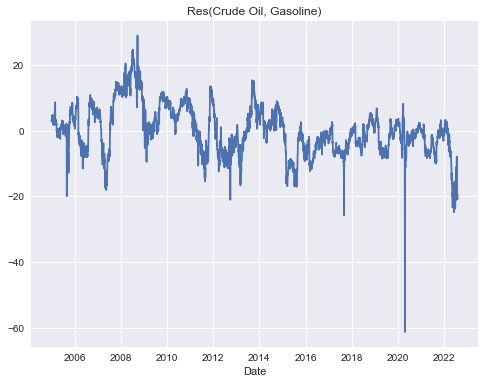

In [8]:
y_commodity = price_commodity.loc[:,'Crude Oil']
x_commodity = price_commodity.loc[:,'Gasoline']

beta_commodity, resid_commodity, summary_commodity = OLS(y_commodity, x_commodity)
# resid.plot(figsize=(10,8))
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(resid_commodity)
ax.set_title('Res(Crude Oil, Gasoline)')
ax.set_xlabel('Date')


### 1.3.2 Filtering of Crypto Basket
The cryptocurrency market is very volatile and we cannot be sure that these pairs have all time covariance, so we have to look forward a year and find the relationship over that time.

Fortunately, we found that the BNB-ETH pair was a possible cointegrated pair in the previous year, so we can assume that this relationship will be maintained in the following short period of time.

In [9]:
pairs_selection(price_crypto).head()

,p-value,aic
"(BNB-USD, ETH-USD)",0.020690,2733.902058
"(BNB-USD, SOL-USD)",0.033754,3039.532410
"(ADA-USD, DOGE-USD)",0.038774,-903.598281
"(BTC-USD, LTC-USD)",0.071388,6225.059952
"(ETH-USD, SOL-USD)",0.083243,4520.747225


Text(0.5, 0, 'Date')

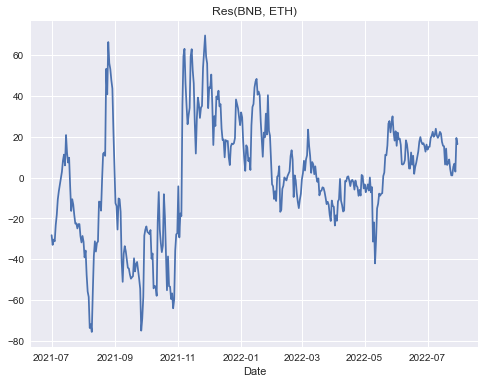

In [10]:
y_crypto = price_crypto.loc[:,'BNB-USD']
x_crypto = price_crypto.loc[:,'ETH-USD']

beta_crypto, resid_crypto, summary_crypto = OLS(y_crypto, x_crypto)
# resid.plot(figsize=(10,8))
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(resid_crypto)
ax.set_title('Res(BNB, ETH)')
ax.set_xlabel('Date')

## 1.4 Cointegration Analysis
The results of cointegration tests reveal situations in which two or more non-stationary time series are combined in such a way that they are unable to deviate from equilibrium over the long run. The tests help determine how sensitive two variables are to the same average price over a certain time period.
### 1.4.1 ENGLE-GRANGER STEP-1. Cointegrated Residual
We can perform the 1st step of EG process which is to estimate the model from OLS:
$$y_t = \beta_{Coint}*x_t + \mu_e + \epsilon_t$$
Then our naive cointegrated residual is:
- Commodity pair
$$e_t = Crude Oil_t - 33.48*Gasoline_t - 1.33$$
- Crypto pair
$$e_t = BNB_t - 0.11*ETH_t - 87.76$$


In [11]:
summary_commodity

,Params,Error,T-stats,P-values
const,1.33,0.39,3.45,0.0
Gasoline,33.48,0.18,188.81,0.0


In [12]:
summary_crypto

,Params,Error,T-stats,P-values
const,87.76,4.58,19.17,0.0
ETH-USD,0.11,0.00,72.09,0.0


In [13]:
summary, p, aic = ADF_test(resid_commodity, 'Crude Oil, Gasoline')
display(summary)
summary, p, aic = ADF_test(resid_crypto, 'BNB, ETH') 
display(summary)

---------ADF result--------:
p-value = 0.002724 The series Crude Oil, Gasoline is likely stationary.


,"Estimate ΔRes(Crude Oil, Gasoline)","SD of Estimate ΔRes(Crude Oil, Gasoline)","t-Statistic ΔRes(Crude Oil, Gasoline)","P-value ΔRes(Crude Oil, Gasoline)"
const,-0.006259,0.024405,-0.256486,0.797587
e_t-1,-0.018510,0.003275,-5.652607,0.000000
Δe_t-1,-0.214121,0.014725,-14.541758,0.000000


---------ADF result--------:
p-value = 0.02069 The series BNB, ETH is likely stationary.


,"Estimate ΔRes(BNB, ETH)","SD of Estimate ΔRes(BNB, ETH)","t-Statistic ΔRes(BNB, ETH)","P-value ΔRes(BNB, ETH)"
const,0.123159,0.470967,0.261503,0.793843
e_t-1,-0.059283,0.016946,-3.498347,0.000522
Δe_t-1,0.032226,0.050549,0.637515,0.524164


Both pairs passed the ADF test.

### ENGLE-GRANGER STEP 2. Error correction equations
In general form, 
$$\Delta P_t^A = \varphi \Delta P_t^B - (1-\alpha) \tilde e^A_{t-1} + \epsilon_t$$

In the other way around:
$$\Delta P_t^B = \varphi \Delta P_t^A - (1-\alpha) \tilde e^A_{t-1} + \epsilon_t$$

In [14]:
def EG_err_corr1(S1, S2, e, name):
    '''
    :param S1: dataframe-like, the price of asset A
    :param S2: dataframe-like, the price of asset B
    :param e: dataframe-like, the residual between A and B
    '''
    dS1 = np.array(S1.diff()).flatten()
    dS2 = np.array(S2.diff()).flatten()
    
    e = np.array(e.shift(1)).flatten()
    df_to_fit = pd.DataFrame({'ΔPA_t':dS1,
                             'ΔPB_t':dS2,
                             'e_t-1':e}).dropna()
    
    x = df_to_fit[['ΔPB_t','e_t-1']]
    y = df_to_fit['ΔPA_t']
    
    model = sm.OLS(y, x).fit()

    summary = pd.DataFrame({f"Estimate Δ{name}":model.params,
                           f"SD of Estimate Δ{name}":model.bse,
                           f"t-Statistic Δ{name}":model.tvalues,
                           f"P-value Δ{name}":model.pvalues})
    summary = np.round(summary,6)
    return summary, model.pvalues
summary, p = EG_err_corr1(y_commodity, x_commodity, resid_commodity, 'Gasoline')
display(summary)
summary, p = EG_err_corr1(y_crypto, x_crypto, resid_crypto, 'ETH')
display(summary)

,Estimate ΔGasoline,SD of Estimate ΔGasoline,t-Statistic ΔGasoline,P-value ΔGasoline
ΔPB_t,23.608013,0.465455,50.720279,0.0
e_t-1,-0.022663,0.003172,-7.144839,0.0


,Estimate ΔETH,SD of Estimate ΔETH,t-Statistic ΔETH,P-value ΔETH
ΔPB_t,0.108314,0.003769,28.735137,0.000000
e_t-1,-0.056863,0.016728,-3.399282,0.000745


We now perform **the 2nd step of EG to estimate the Equilibrium Correction Model**, Here we check the significance of -(1-𝛼) term, which ensure the correction the long run equilibrium. In error correction equation the p-value is significantly showing 0.

In [15]:
def EG_err_corr2(S1, S2, e, name):
    '''
    :param S1: dataframe-like, the price of asset A
    :param S2: dataframe-like, the price of asset B
    :param e: dataframe-like, the residual between A and B
    '''
    dS1 = np.array(S1.diff()).flatten()
    dS2 = np.array(S2.diff()).flatten()
    
    e = np.array(e.shift(1)).flatten()
    df_to_fit = pd.DataFrame({'ΔPA_t':dS1,
                             'ΔPB_t':dS2,
                             'e_t-1':e}).dropna()
    
    x = df_to_fit[['ΔPA_t','e_t-1']]
    y = df_to_fit['ΔPB_t']
    
    model = sm.OLS(y, x).fit()

    summary = pd.DataFrame({f"Estimate Δ{name}":model.params,
                           f"SD of Estimate Δ{name}":model.bse,
                           f"t-Statistic Δ{name}":model.tvalues,
                           f"P-value Δ{name}":model.pvalues})
    summary = np.round(summary,6)
    
    return summary, model.pvalues
summary, p = EG_err_corr2(y_commodity, x_commodity, resid_commodity, 'Crude Oil')
display(summary)
summary, p = EG_err_corr2(y_crypto, x_crypto, resid_crypto, 'BNB')
display(summary)

,Estimate ΔCrude Oil,SD of Estimate ΔCrude Oil,t-Statistic ΔCrude Oil,P-value ΔCrude Oil
ΔPA_t,0.015604,0.000308,50.720279,0.0
e_t-1,0.000438,0.000082,5.359113,0.0


,Estimate ΔBNB,SD of Estimate ΔBNB,t-Statistic ΔBNB,P-value ΔBNB
ΔPA_t,6.260336,0.217863,28.735137,0.000000
e_t-1,0.235383,0.128485,1.831987,0.067712


Now, we estimate the EG correction equation "other way around", both shows the significance.
From the absolute value of t-stas, the first way is the more important model. So the pair is considered to be cointegrated.


## 1.5 Ornstein-Uhlenbeck process

In order to find the optimal $\beta_{Coint}$ to build the best mean reversion portfolio, we can fit the OU process.
 
The Ornstein-Uhlenbeck process is described by the following SDE:

$$ dX_t = \kappa (\theta - X_t) dt + \sigma dW_t $$

The parameters are:
- $\theta \in \mathbb{R}$: The long-term average, around which all trajectories of $X_t$ oscillate, is the mean level.

- $\kappa > 0$: the speed of mean reversion, represents the velocity at which such trajectories will regroup around mean level

- $\sigma > 0$: instantaneous volatility, measures the amplitude of randomness entering the system.


At this point we can solve the SDE:

$$ X_t = \theta + (X_0 - \theta)e^{-\kappa t} + \int_0^t \sigma\, e^{\kappa (s-t)} dW_s .$$


### Moments:

The **mean** of $X_t$ is:

$$ \begin{aligned}
\mathbb{E}[X_t] &= \mathbb{E}\biggl[ \theta + (X_0 - \theta)e^{-\kappa t} + \int_0^t \sigma\, e^{\kappa (s-t)} dW_s \biggr] \\
                &= \theta + (X_0 - \theta)e^{-\kappa t}    
\end{aligned}$$

The **covariance** is:

$$ \begin{aligned}
\text{Cov}[X_s, X_t] &= \frac{\sigma^2}{2\kappa} \biggl( e^{-\kappa |t-s|} - e^{-\kappa (s+t)}\, \biggr),  
\end{aligned}$$

The **variance** is: 

$$ \text{Var}[X_t] = \text{Cov}[X_t, X_t] = \frac{\sigma^2}{2\kappa} \biggl( 1- e^{-2 \kappa t} \biggr).$$

So, we can obtain the **mean**: $\theta$ and the **variance**: $\frac{\sigma^2}{2\kappa}$




We can discretize the SDE using the Euler-Maruyama numerical method:

Let us consider the solution of the OU SDE obtained above. We can compute $X_{n+1}$ and consider the initial value at time $n$.

$$ X_{n+1} = \theta + (X_n - \theta)e^{-\kappa \Delta t} + \sqrt{\frac{\sigma^2}{2\kappa} \bigl( 1- e^{-2 \kappa \Delta t} \bigr)} \; \epsilon_n $$ 

with $\epsilon_n \sim \mathcal{N}(0,1)$.



### Estimation of parameters

We can compute $X_{t+\Delta t}$ and consider the initial value at time $t$.

$$ \begin{aligned}
X_{t+\Delta t} &= \theta + (X_t - \theta)e^{-\kappa \Delta t} + \int_t^{t+\Delta t} \sigma\, e^{\kappa (s-t)} dW_s \\
               &= \theta \bigl( 1-e^{-\kappa \Delta t} \bigr) + e^{-\kappa \Delta t} X_t + \int_t^{t+\Delta t} \sigma\, e^{\kappa (s-t)} dW_s \\
               &= \alpha + \beta X_t + \epsilon_t
\end{aligned} $$

where $\alpha = \theta \bigl( 1-e^{-\kappa \Delta t} \bigr)$, $\beta = e^{-\kappa \Delta t}$ and with $\epsilon_t \sim \mathcal{N}\biggl( 0, \frac{\sigma^2}{2\kappa} \bigl( 1- e^{-2 \kappa \Delta t} \bigr)\biggr)$.

So, this confirms the saying from "The Ornstein–Uhlenbeck process can also be considered as the continuous-time analogue of the discrete-time AR(1) process." and we are able to guarantee the AR(1) process to estimate the params on the spread. 

let us use the usual OLS method to estimate $\alpha$, $\beta$ and $\sigma$.
Then, we can obtain the parameters from the formulas:

$$ \kappa = - \frac{\log \beta}{\Delta t}, \quad \theta = \frac{\alpha}{1-\beta}, \quad 
\sigma = \text{Std}[\epsilon_t] \sqrt{ \frac{2\kappa}{1-\beta^2} }$$

we can obtain almost consistent parameters to those params obtained by MLE.

Halflife:
$$Halflife(days) = \frac{ln(2)}{\theta*dt}$$

In [16]:
class OU_process:
    def __init__(self, freq = 'D'):
        if freq =='D':
            self.dt = 1/252
        elif freq=='H':
            self.dt = 1/252/60
        elif freq=="M":
            self.dt = 1/252/60/60
        
    def fit(self,resid, verbose = True):
        X = np.array(resid[:-1]).flatten()
        Y = np.array(resid[1:]).flatten()

        model = sm.OLS(Y, sm.add_constant(X)).fit()
        alpha, beta = model.params
        kappa = - np.log(beta)/self.dt
        theta = alpha/(1-beta)
        res = Y - beta * X - alpha                   # residuals
        std_resid = np.std(res, ddof=2)
        sigma = std_resid * np.sqrt(2*kappa/(1-beta**2))
        sigma_eq = std_resid*np.sqrt(1/(1-beta**2))
        halflife = np.log(2)/kappa/self.dt
        if verbose:
            print("OU process params:")
            print(f"theta = {theta:.4f}")
            print(f"kappa = {kappa:.4f}")
            print(f"sigma = {sigma:.4f}")
            print(f"sigma_eq = {sigma_eq:.4f}")
            print(f"halflife = {halflife:.4f}")
        self.params = {'theta':theta,'kappa':kappa, 'sigma':sigma,'sigma_eq':sigma_eq,'halflife':halflife}
        return self



### 1.5.1 Commodity Basket OU process fitting
In this step, I will apply the Ornstein-Uhlenbeck process for modellling the cointegration residual for each pair in the commodity and crypto basket. The parameters can be easily estimated from last funcion. We are interested in the pair with larger kappa so that they are expected to revert to mean level more quickly.

In [17]:
def OU_process_pairs_selection(prices, kappa_thres = 5):
    res = pd.DataFrame(columns = ['theta','kappa', 'sigma','sigma_eq','halflife'])
    resid_df = pd.DataFrame(index = prices.index)
    n = prices.shape[1]
    for i in range(n):
        for j in range(i+1, n):
            pairs = prices.iloc[:,[i,j]]
            pairs_name = f"({pairs.columns[0]}, {pairs.columns[1]})"
            y = pairs.iloc[:,0]
            x = pairs.iloc[:,1]
            beta, resid, summary = OLS(y, x)
            
            params = OU_process().fit(resid,verbose=False).params
            if params['kappa']>kappa_thres:
                res.loc[pairs_name] = list(params.values())
                resid_df[pairs_name] = resid
    res.sort_values(by=['kappa'],ascending=False,inplace=True)
    return res, resid_df


In [18]:
OU_params_commodity, resid_df = OU_process_pairs_selection(price_commodity)
OU_params_commodity

,theta,kappa,sigma,sigma_eq,halflife
"(Crude Oil, Gasoline)",-0.207127,6.117489,26.657224,7.621024,28.553069


In [19]:
OU_params_crypto, resid_df = OU_process_pairs_selection(price_crypto, kappa_thres=8)
OU_params_crypto

,theta,kappa,sigma,sigma_eq,halflife
"(ADA-USD, DOGE-USD)",0.031668,15.140480,1.171938,0.212971,11.536827
"(BNB-USD, ETH-USD)",1.942881,14.765735,152.346451,28.034306,11.829623
"(BNB-USD, SOL-USD)",-0.882384,11.771120,222.329248,45.821860,14.839123
"(DOGE-USD, LTC-USD)",-0.004348,11.545765,0.128994,0.026844,15.128758
"(BTC-USD, ETH-USD)",-377.101505,8.481125,12859.326440,3122.313353,20.595509
"(BTC-USD, LTC-USD)",517.008926,8.168894,15638.369402,3868.965319,21.382710


From OU process pair selection part, we can conclude that the Crude Oil - Gasoline pair and BNB-ETH pair have high mean reversion rate, which satisfies our expection, so the pairs we selected previously are reliable.

## 1.6 Time series split into train and test set
Before we do signal generation, we will apply some machine learning-inspired backtesting, such as spliting data into train/test subsets. We will train the best parameters on the training data set and regard the test set as real-time trading. So it is easier to deploy time series cross validation in the following steps.

Considering the halflife of our model, we need to have enough long time period in the test dataset. So we will ensure the cointegration window will contain at least one year and the backtesting window should be more than half year to maintain at least one trade during the subsets.

We will seperate 70% time series into training set and remaining 30% into test set.

In [20]:
pair_commodity = price_commodity[['Crude Oil','Gasoline']]
pair_crypto = price_crypto[['BNB-USD','ETH-USD']]
prices_train_commodity, prices_test_commodity= train_test_split(pair_commodity, test_size=0.3,shuffle=False)
prices_train_crypto, prices_test_crypto = train_test_split(pair_crypto, test_size=0.3,shuffle=False)

## 1.7 Signal Generation

The pair candidates have been selected and their cointegration tests run too. The following process will run into the backtesting phase. Before that, we should generate trading signal series from the prices. First, we must find when a position should be opened and liquidated. Now that we have 𝜃θ - the mean reversion average level - and $\sigma_{eq}$ from OU process, we are able to standardize the residuals and set the threshold:

Let's keep our trading rule as simple as possible, set the Z to 1.
- Entry on $\mu_e\pm Z\sigma_{eq}$ 
    - if > $Z\sigma$: Go short Y and long X at a ratio of H of X for every dollor of Y
- Exit on $\mu_e$

### 1.7.1 Commodity Signal

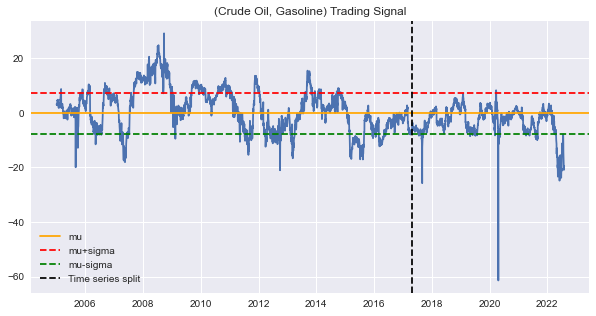

In [21]:
mu_commodity = OU_params_commodity.loc['(Crude Oil, Gasoline)']['theta']
sig_commodity = OU_params_commodity.loc['(Crude Oil, Gasoline)']['sigma_eq']
hl_commodity = OU_params_commodity.loc['(Crude Oil, Gasoline)']['halflife']

fig,ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(resid_commodity)
ax.axhline(mu_commodity,color = 'orange',label = "mu")
ax.axhline(mu_commodity+sig_commodity,color = 'red',linestyle ='--',label = "mu+sigma")
ax.axhline(mu_commodity-sig_commodity,color = 'green',linestyle ='--',label = "mu-sigma")
ax.axvline(prices_train_commodity.index[-1],color = 'black',linestyle ='--',label = "Time series split")
ax.set_title("(Crude Oil, Gasoline) Trading Signal")
ax.legend(loc='lower left')

### 1.7.2 Crypto Signal

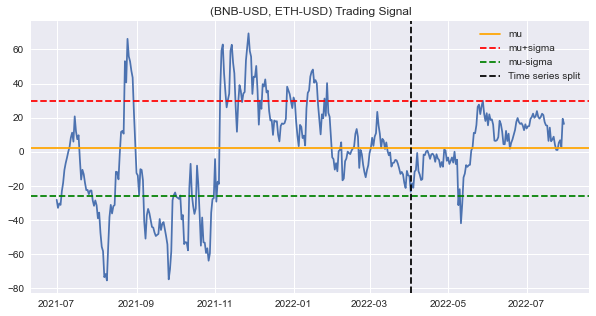

In [22]:
mu_crypto = OU_params_crypto.loc['(BNB-USD, ETH-USD)']['theta']
sig_crypto = OU_params_crypto.loc['(BNB-USD, ETH-USD)']['sigma_eq']
hl_crypto = OU_params_crypto.loc['(BNB-USD, ETH-USD)']['halflife']

fig,ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(resid_crypto)
ax.axhline(mu_crypto,color = 'orange',label = "mu")
ax.axhline(mu_crypto+sig_crypto,color = 'red',linestyle ='--',label = "mu+sigma")
ax.axhline(mu_crypto-sig_crypto,color = 'green',linestyle ='--',label = "mu-sigma")
ax.axvline(prices_train_crypto.index[-1],color = 'black',linestyle ='--',label = "Time series split")
ax.set_title("(BNB-USD, ETH-USD) Trading Signal")
ax.legend()

# Part II: Backtesting
In this section, we are going to implement the following steps:

- Perform systematic backtesting of your trading strategy platform to produce drawdown plots, rolling Sharpe ratio and rolling beta
- keep delivering staionary spread over 3-6 months. Re-estmate cointergration by shifting data 1-2 weeks and report beta and EG.
- Use Machine-learning-inspired backtesting, such as spliting data, time series CV.

## 2.1 Pairs trading backtesting
I have designed a pairs trading backtesting function below to iterate every time point and implement the predetermined strategy. This function will return a trackable trading dataframe and various visualized trading parameters, including cumulative returns, residual with signal, pair prices, maximum drawdown, 6-month rolling Sharpe ratio and 6-month rolling volatility.

In [23]:

import matplotlib.dates as mdates
def pairs_trading_backtesting(prices, mu, sigma, hedge_ratio, Z=1, money_init=10000, bet_size=0.2,bid_ask_spread=0.0,commission_cost_pct=0.0, verbose=False, plot=True):
    '''
    pair_prices: dataframe, first column is Y, second column will be X
    mu: float, the average mean reversion level
    sigma: float, the volatility of the residual series
    Z: float, the multiple to adjust trading threshold
    money_init: float, the initial money setting
    bet_size: float, the proportion of cash to invest for each trade
    bid_ask_spread: float, the absolute value of bid ask spread
    commission_cost_pct: float, the percentage of commission cost for each trade
    verbose: bool, print each transaction information or not
    plot: bool, print strategy details in figures or not
    '''
    global Y_shares
    global X_shares
    global Y_assetValue
    global X_assetValue
    global Cash
    global t
    initial = money_init
#     Z=1
    ## Set the leverage for the percentage of money in each transaction. 
    ## If bet_size>1, we borrow money and have a leverage.
    ## If bet_size<1, we partially invest and hold a percentage of cash.

    pair_prices = prices.copy()
    Y = pair_prices.iloc[:,0]
    X = pair_prices.iloc[:,1]


    _, residuals, _ = OLS(Y,X)
    mu = mu
    sigma = sigma

    pair_prices['beta_coint'] = hedge_ratio
    pair_prices['resid'] = residuals


    pair_prices['normalized resid'] = (residuals-mu)/sigma

    open_signal = 0
    close_signal = 0
    hold_position = 0
    pair_prices

    # Cash
    Cash = initial
    # Asset
    Y_shares = 0
    X_shares = 0
    Y_assetValue = 0
    X_assetValue = 0
    PortfolioValue = Y_assetValue+X_assetValue
    # Equity
    Equity = Cash + PortfolioValue
    Trade_n = 0
    
    pair_prices['Cash'] = np.nan
    pair_prices[f'{Y.name}_shares'],pair_prices[f'{X.name}_shares'] = np.nan,np.nan
    pair_prices[f'{Y.name}_values'],pair_prices[f'{X.name}_values'] = np.nan,np.nan
    pair_prices['PortfolioValue'],pair_prices['Equity'] = np.nan,np.nan
    pair_prices['#Trade'] = np.nan
    def place_order(contract, action, quantity, verbose=verbose):
        '''
        place order for pairs trading
        @params contract: 'X' or 'Y', trade asset X or Y
        @params action: int, 1 or -1, long or short the asset
        @params quantity: the quantitiy of placing orders
        '''
        global Y_shares
        global X_shares
        global Y_assetValue
        global X_assetValue
        global Cash
        global t
        if contract=='Y':
            Y_shares += action * quantity

            ## bid ask price correction
            if action==1:
                ## buy asset at ask price
                orderValue = action * quantity * (Y_price_t+bid_ask_spread)
            elif action==-1:
                ## buy asset at ask price
                orderValue = action * quantity * (Y_price_t-bid_ask_spread)

            cost = abs(orderValue*commission_cost_pct)

            Cash -= (orderValue + cost)
            Y_assetValue += orderValue
            if verbose:
                print(f"{t}: order placed! we ordered {action *quantity} numbers of {Y.name} at price {Y_price_t}.")

        if contract=='X':
            X_shares += action * quantity

            ## bid ask price correction
            if action==1:
                ## buy asset at ask price
                orderValue = action * quantity * (X_price_t+bid_ask_spread)
            elif action==-1:
                ## buy asset at ask price
                orderValue = action * quantity * (X_price_t-bid_ask_spread)


            cost = abs(orderValue*commission_cost_pct)

            Cash -= (orderValue + cost)
            X_assetValue += orderValue
            if verbose:
                print(f"{t}: order placed! we ordered {action *quantity} numbers of {X.name} at price {X_price_t}.")
    
    
    for t in pair_prices.index:
        trade_size = Cash * bet_size
        ## Before the market: nothing to do yet

        ## During the market: we calculate the indicator, and place order or just hold
        Y_price_t =  pair_prices.loc[t,Y.name]
        X_price_t =  pair_prices.loc[t,X.name]
        beta = pair_prices.loc[t,'beta_coint']
        spread = Y_price_t - beta * X_price_t
        order_number = abs(trade_size/(Y_price_t + beta * X_price_t))
    #     print("order:",order_number)
        if pair_prices.loc[t,'normalized resid']>=Z and hold_position==0:
            ### if open signal ==1, which means e_t = Y-𝛽X-𝛼 beyond the upper threshold
            ### We go short Y and long X to expect the e_t going down
            ## place_order(contract, action, quantity)
            place_order('Y', action = -1, quantity = order_number)
            place_order('X', action = 1, quantity = order_number * beta)
            hold_position = -1
            Trade_n+=1

        if pair_prices.loc[t,'normalized resid']<=-Z and hold_position==0:
            ### if open signal ==-1, which means e_t = Y-𝛽X-𝛼 less than the lower threshold
            ### We go long Y and short X to expect the e_t going up
            ## place_order(contract, action, quantity)
            place_order('Y', action = 1, quantity = order_number)
            place_order('X', action = -1, quantity = order_number * beta)
            hold_position = 1
            Trade_n+=1
            
        if hold_position==-1 and pair_prices.loc[t,'normalized resid']<=0:
            ## close position
            place_order('Y', action = 1, quantity = abs(Y_shares))
            place_order('X', action = -1, quantity = abs(X_shares))
            hold_position = 0

        if hold_position==1 and pair_prices.loc[t,'normalized resid']>=0:
            ## close position
            place_order('Y', action = -1, quantity = abs(Y_shares))
            place_order('X', action = 1, quantity = abs(X_shares))
            hold_position = 0
        ## after the market: recalculate the daily PnL, returns, market value, equity, etc.
        Y_assetValue = Y_shares * Y_price_t
        X_assetValue = X_shares * X_price_t
        PortfolioValue = (Y_assetValue+X_assetValue)
        Equity = Cash + PortfolioValue
        pair_prices.loc[t,'Cash'], pair_prices.loc[t,'PortfolioValue'], pair_prices.loc[t,'Equity'] = Cash, PortfolioValue, Equity
        pair_prices.loc[t,f'{Y.name}_shares'], pair_prices.loc[t,f'{X.name}_shares'] =  Y_shares, X_shares
        pair_prices.loc[t,f'{Y.name}_values'], pair_prices.loc[t,f'{X.name}_values'] =  Y_assetValue, X_assetValue
        pair_prices.loc[t,'#Trade'] = Trade_n
#         print(t,Cash, Y_assetValue, X_assetValue,PortfolioValue,Equity)
    pair_prices['return'] = pair_prices['Equity'].pct_change()
    
    
    ##############
    # Draw Plots#
    #############
    if plot:
        fig, axes = plt.subplots(3,2,figsize = (18,18))
        ax = axes[0][0]
        ax.plot(pair_prices['Equity']/initial-1)
        ax.set_title('P&L(Cumulative return)',fontsize=14)


        ax = axes[0][1]
        ax.plot(pair_prices['resid'])
        ax.axhline(mu,color = 'orange',label = "mu")
        ax.axhline(mu+Z*sigma,color = 'red',linestyle ='--',label = "upper threshold")
        ax.axhline(mu-Z*sigma,color = 'green',linestyle ='--',label = "lower threshold")
        ax.set_title("Residuals with trading signals",fontsize=14)
        ax.legend()

        ax = axes[1][0]
        ax.plot(pair_prices.iloc[:,0], label = pair_prices.columns[0])
        ax.plot(pair_prices.iloc[:,1]*pair_prices.beta_coint, label = "Beta * "+pair_prices.columns[1])
        ax.set_title("Prices with trading signals",fontsize=14)
        ax.legend()


        ax = axes[1][1]
        rolling_max = pair_prices['Equity'].expanding().max()
        max_drawdown = pair_prices['Equity']/rolling_max-1
        ax.plot(max_drawdown)
        ax.set_title("Maximum Drawdown",fontsize=14)


        ax = axes[2][0]
        rolling_SR = pair_prices['return'].rolling(20).apply(lambda x: (x.mean()) / x.std(), raw = True)
        rolling_SR.ffill(inplace=True)
        rolling_SR.plot(ax = ax,lw=2, color='orange',  label='Sharpe').axhline(y = rolling_SR.mean(), color = "blue", lw = 2,
                                                         linestyle = '--',label = 'Average')

        ax.set_title("Rolling Sharpe Ratio (1-month)",fontsize=14)
        ax.legend()
  

        ax = axes[2][1]
        rolling_vol = pair_prices['return'].rolling(20).std()*np.sqrt(252)
        rolling_vol.ffill(inplace=True)
        rolling_vol.plot(ax = ax,lw=2, color='orange',  label='Vol').axhline(y =rolling_vol.mean(), color = "blue", lw = 2,
                                                         linestyle = '--',label = 'Average')

        ax.set_title("Rolling Annualised Volatility (1-month)",fontsize=14)
        ax.legend()
    
        ##################
        # Trading Outcome#
        ##################
        print(f"Start date:", pair_prices.index[0])
        print(f"End date:", pair_prices.index[-1])
        print(f"Net Profit: {pair_prices['Equity'][-1]-initial:.2f}")
        print(f"Total return: {(pair_prices['Equity'][-1]/initial - 1)*100:.2f}%")
        


    return pair_prices

### 2.1.1 Crude oil-gasoline backtesting on the training set (Z=1)

Start date: 2005-01-03 00:00:00
End date: 2017-04-24 00:00:00
Net Profit: 33734.65
Total return: 337.35%


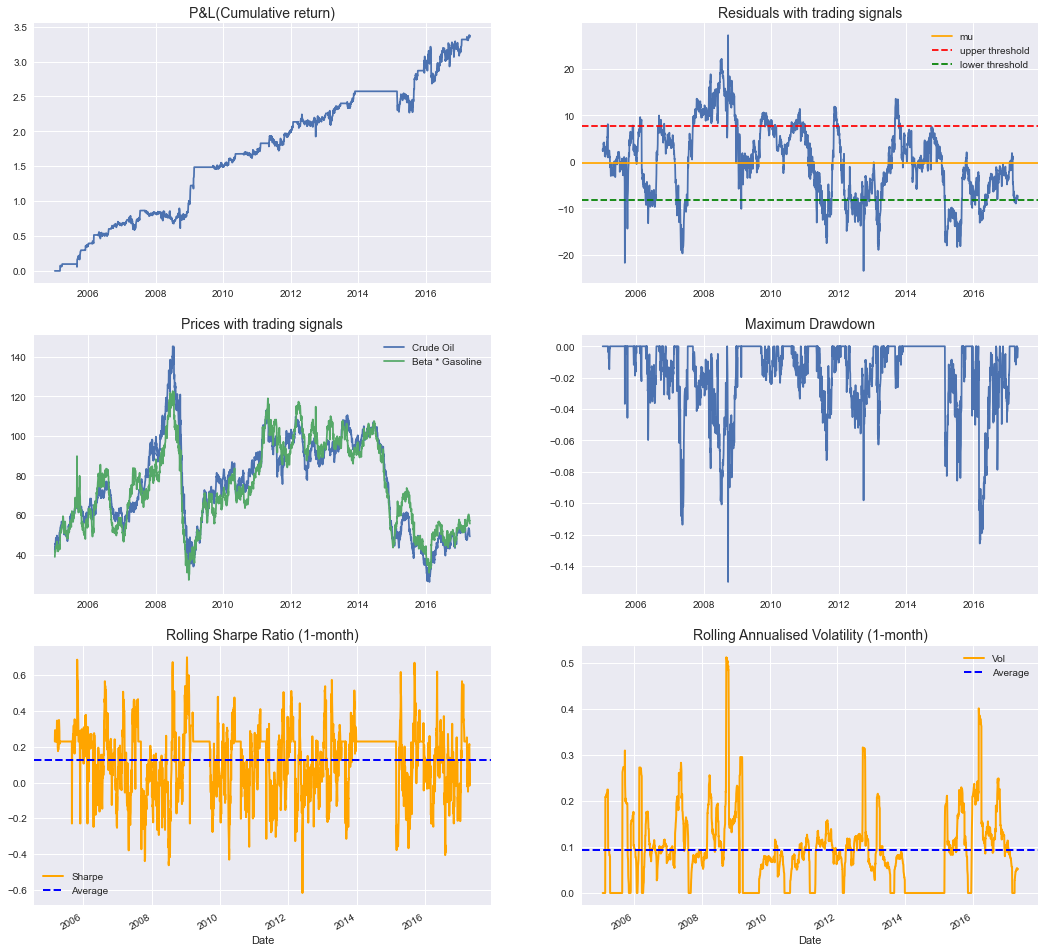

In [24]:
pair_commodity = prices_train_commodity
pair_prices = pair_commodity.copy()
Y = pair_prices.iloc[:,0]
X = pair_prices.iloc[:,1]


beta, residuals, _ = OLS(Y,X)
OU_params = OU_process().fit(residuals,verbose=False).params
mu = OU_params['theta']
sigma = OU_params['sigma_eq']
trade_df = pairs_trading_backtesting(pair_commodity, 
                                      mu = mu, sigma = sigma, 
                                      hedge_ratio = beta, 
                                      Z=1, 
                                      money_init=10000, 
                                      bet_size=1,
                                      bid_ask_spread=0.0,
                                      commission_cost_pct=0.0,
                                      verbose=False,
                                      plot=True)
# trade_df.tail()

### 2.1.2 Backtesting for BNB-ETH pair on training set (Z=1)

Start date: 2021-07-01 00:00:00
End date: 2022-04-02 00:00:00
Net Profit: 4620.56
Total return: 46.21%


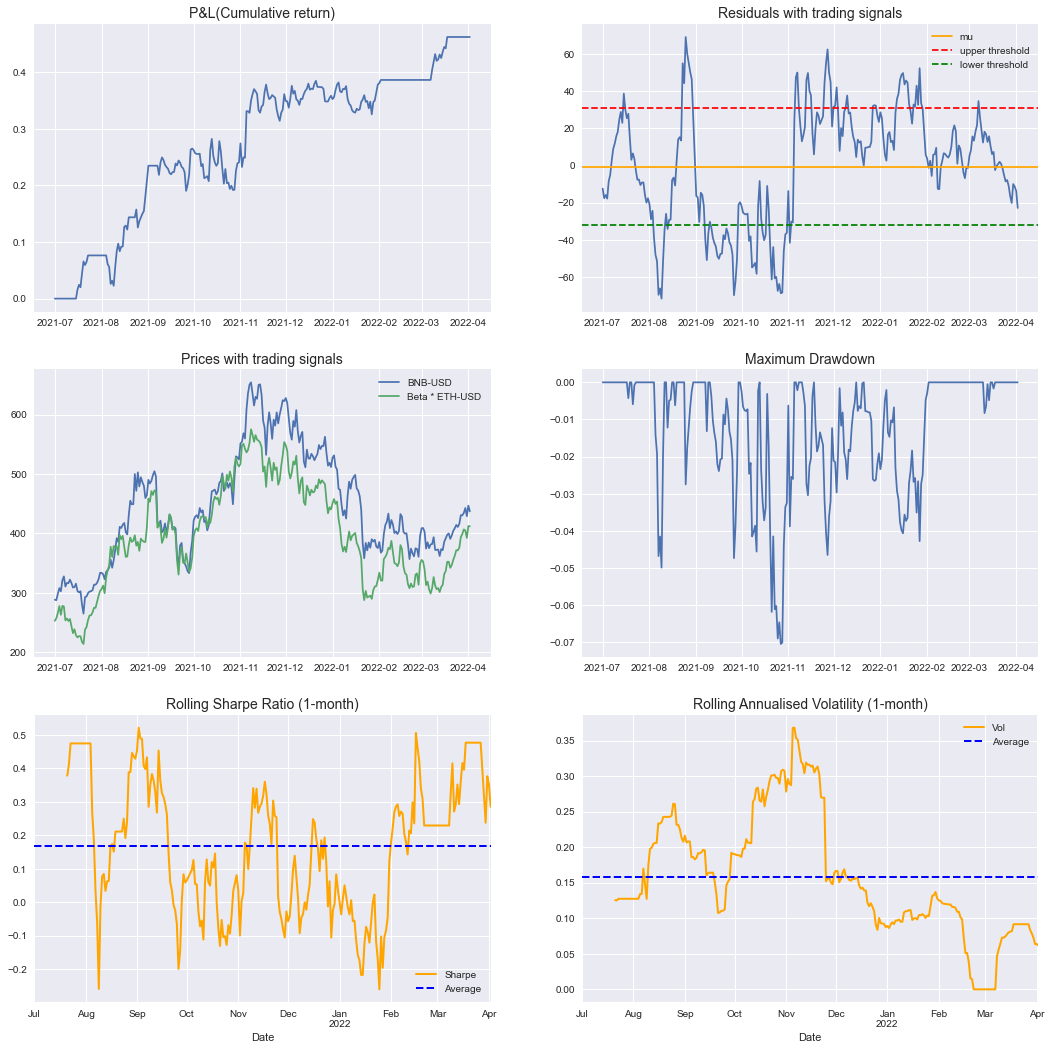

In [26]:
pair_crypto = prices_train_crypto
pair_prices = pair_crypto.copy()
Y = pair_prices.iloc[:,0]
X = pair_prices.iloc[:,1]


beta, residuals, _ = OLS(Y,X)
OU_params = OU_process().fit(residuals,verbose=False).params
mu = OU_params['theta']
sigma = OU_params['sigma_eq']
trade_df = pairs_trading_backtesting(pair_crypto, 
                                      mu = mu, sigma = sigma, 
                                      hedge_ratio = beta, 
                                      Z=1, 
                                      money_init=10000, 
                                      bet_size=1,
                                      bid_ask_spread=0.0,
                                      commission_cost_pct=0.0,
                                      verbose=False,
                                      plot=True)
# trade_df.tail()

## 2.2 Backtesting params optimization
At first, with Z=1, we got the backtest result. But it may not be the best entry signal. We plan to vary Z up and down to calculate the highest gain/loss for each threshold. But this may lead to overfitting problem, so if we optimize only on the training set and apply the best value on the test set, the overfitting problem can be solved.

### $Z_{opt}$ optimization

In [27]:
def find_optimized_Z(pair_prices, start, end, n_steps, mu, sigma, beta):

    
    pair_prices = pair_prices.copy()
    Y = pair_prices.iloc[:,0]
    X = pair_prices.iloc[:,1]
    res = pd.DataFrame(columns = ['PnL','#Trade'])

    for z in np.linspace(start, end, n_steps):
        df = pairs_trading_backtesting(pair_prices, 
                                              mu = mu, sigma = sigma, 
                                              hedge_ratio = beta, 
                                              Z=z, 
                                              money_init=10000, 
                                              bet_size=1,
                                              bid_ask_spread=0.0,
                                              commission_cost_pct=0.0,
                                              verbose=False,
                                              plot=False)
        res.loc[z] = [df['Equity'].iloc[-1]/10000-1, df['#Trade'].iloc[-1]]

        
    Z_opt = res['PnL'].idxmax()
    print(f"Z_opt = {Z_opt:.2f} is the best performance parameter with {100*res['PnL'].max():.2f}% cum return")
    fig, axes = plt.subplots(1,2,figsize=(10,5))
    ax = axes[0]
    ax.plot(res['PnL'],label = 'cum return')
    ax.set_title("PnL for each Z")
    ax.set_xlabel('Z')
    ax.legend()

    ax = axes[1]
    ax.plot(res['#Trade'])
    ax.set_title("Number of Trade")
    ax.set_xlabel('Z')
    return Z_opt, res


Z_opt = 1.00 is the best performance parameter with 337.35% cum return


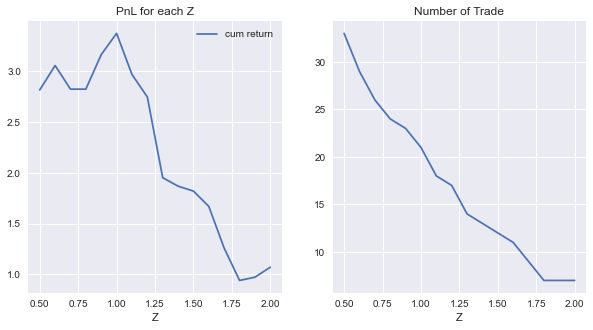

In [28]:

pair_prices = prices_train_commodity
Y = pair_prices.iloc[:,0]
X = pair_prices.iloc[:,1]


beta, residuals, _ = OLS(Y,X)
OU_params = OU_process().fit(residuals,verbose=False).params
mu = OU_params['theta']
sigma = OU_params['sigma_eq']    

Z_opt, report = find_optimized_Z(pair_prices, 0.5,2,16,mu, sigma, beta)
# report

Z_opt = 1.00 is the best performance parameter with 46.21% cum return


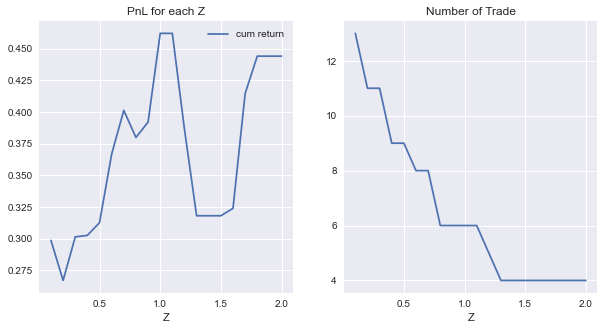

In [29]:

pair_prices = prices_train_crypto
Y = pair_prices.iloc[:,0]
X = pair_prices.iloc[:,1]


beta, residuals, _ = OLS(Y,X)
OU_params = OU_process().fit(residuals,verbose=False).params
mu = OU_params['theta']
sigma = OU_params['sigma_eq']    


Z_opt, report = find_optimized_Z(pair_prices, 0.1,2,20,mu, sigma, beta)
# report

After the simulating Z from 0.5 to 2, the optimum parameter Z for both commodity pair and crypto pair is 1.0.

## 2.3 Optimal $Z_{opt}$ applied to test set

### 2.3.1 Commodity pair backtesting on test set 
Due to the big crash during the 2020 Covid, the maximum drawdown in pairs trading strategies was greatly affected. Therefore, even if we have cointegrated spread to trade, we need to be aware of the market risks. We earned 74.92% return from 2017 to 2022.

Otherwise, our pairs trading strategy worked well through almost all the time period.

Start date: 2017-04-25 00:00:00
End date: 2022-07-29 00:00:00
Net Profit: 7492.47
Total return: 74.92%


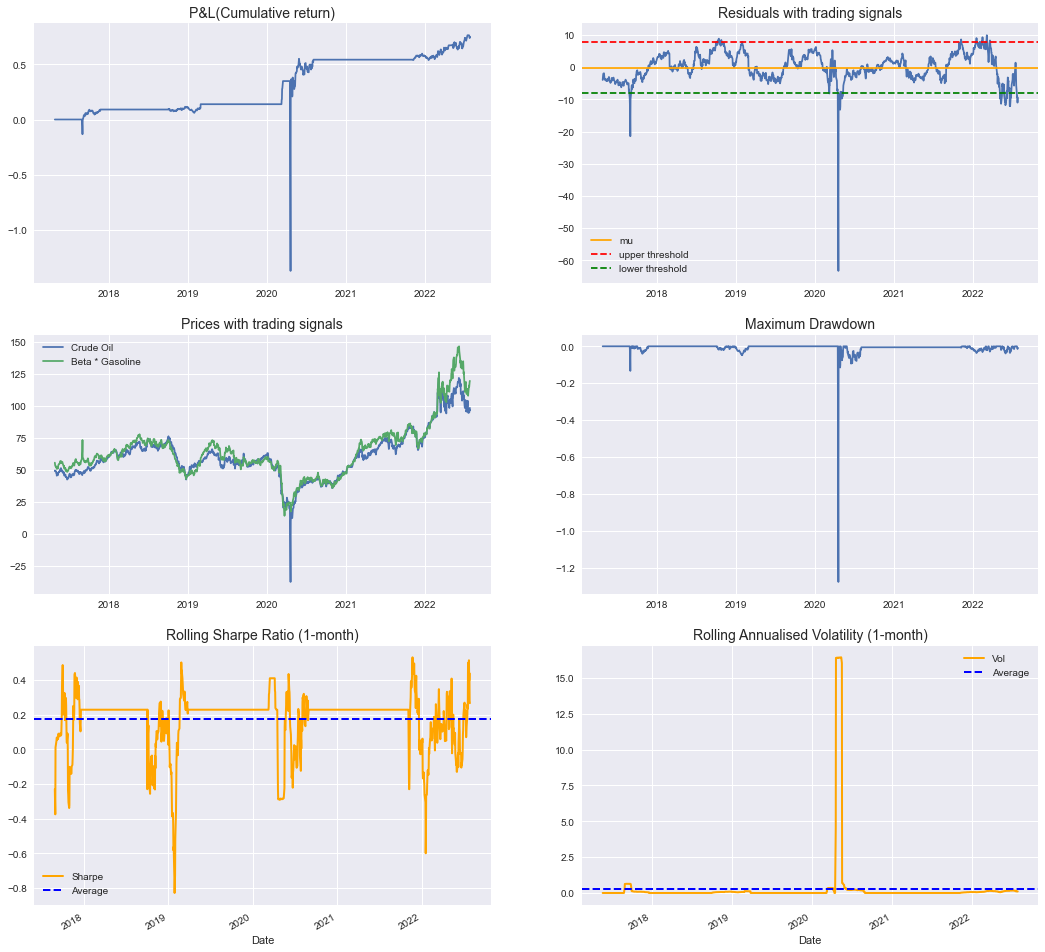

In [30]:
pair_commodity = prices_train_commodity
pair_prices = pair_commodity.copy()
Y = pair_prices.iloc[:,0]
X = pair_prices.iloc[:,1]


beta, residuals, _ = OLS(Y,X)
OU_params = OU_process().fit(residuals,verbose=False).params
mu = OU_params['theta']
sigma = OU_params['sigma_eq']
trade_df = pairs_trading_backtesting(prices_test_commodity, 
                                      mu = mu, sigma = sigma, 
                                      hedge_ratio = beta, 
                                      Z=1, 
                                      money_init=10000, 
                                      bet_size=1,
                                      bid_ask_spread=0.0,
                                      commission_cost_pct=0.0,
                                      verbose=False,
                                      plot=True)
# trade_df.tail()

## 2.3.2. Crypto pair backtesting on test set
Although we don't have enough trade during test dataset, we still got a successful one trade in 2022, and received 8% return with $801.42 net profit.

Start date: 2022-04-03 00:00:00
End date: 2022-07-30 00:00:00
Net Profit: 801.42
Total return: 8.01%


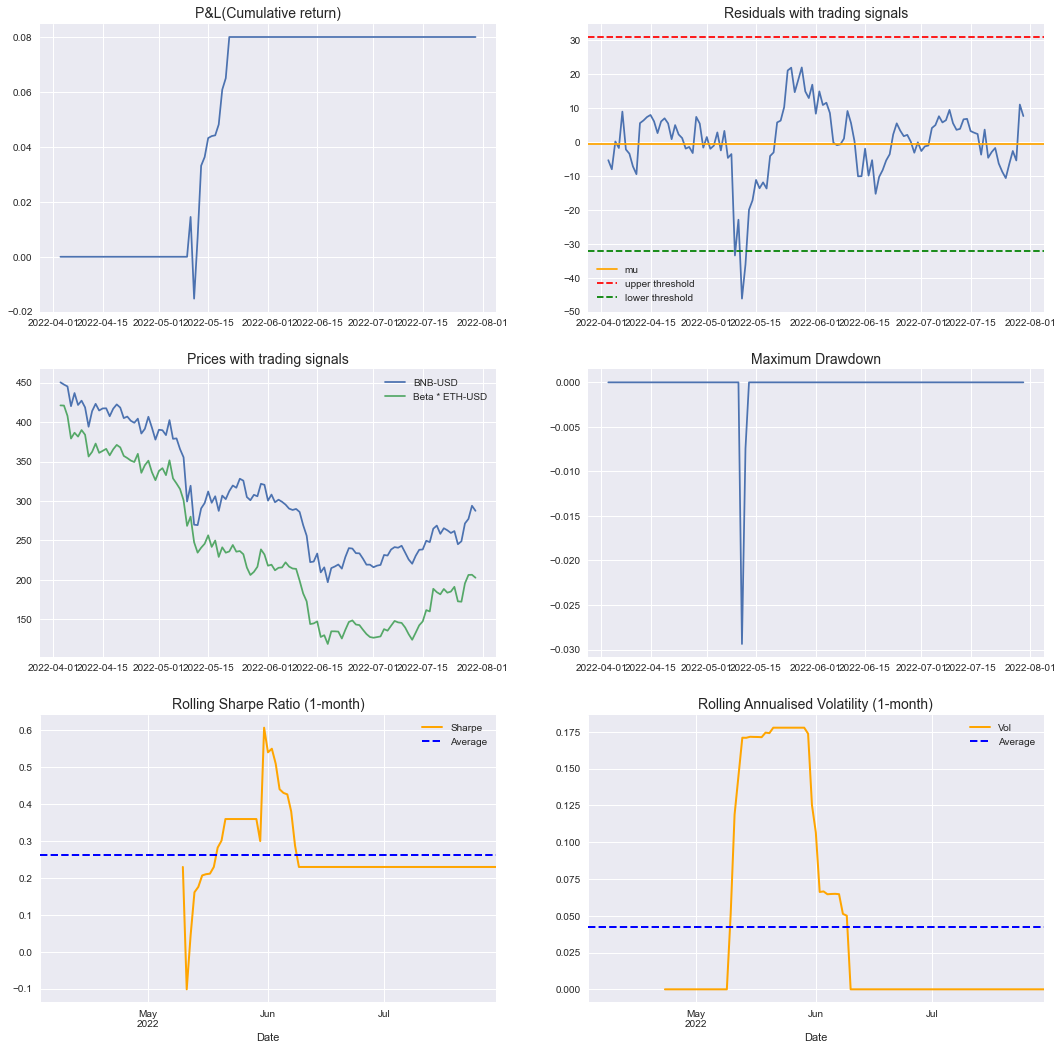

In [31]:
pair_crypto = prices_train_crypto
pair_prices = pair_crypto.copy()
Y = pair_prices.iloc[:,0]
X = pair_prices.iloc[:,1]


beta, residuals, _ = OLS(Y,X)
OU_params = OU_process().fit(residuals,verbose=False).params
mu = OU_params['theta']
sigma = OU_params['sigma_eq']
trade_df = pairs_trading_backtesting(prices_test_crypto, 
                                      mu = mu, sigma = sigma, 
                                      hedge_ratio = beta, 
                                      Z=1, 
                                      money_init=10000, 
                                      bet_size=1,
                                      bid_ask_spread=0.0,
                                      commission_cost_pct=0.0,
                                      verbose=False,
                                      plot=True)
# trade_df.tail()

## 2.4 Bid-Ask Spread impact
Bid-ask spreads are critical to investors and represent the liquidity of a given asset. The bid-ask spread can affect the price at which a purchase or sale is made, which in turn affects the investor's overall portfolio return.
From our analysis below, I tested how bid-ask spreads can have an impact on the total return of a strategy. I set the spreads from 0 to 0.05 with an interval of 0.01. It turns out that as the spreads get larger, the PnL get smaller. When the spread was set to 0.05, the total return was less than half of what it would have been had we not taken into account any spreads.

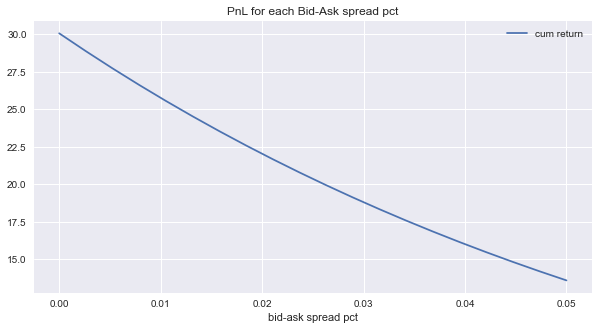

In [32]:
pair_prices = price_commodity[['Crude Oil','Gasoline']]
Y = pair_prices.iloc[:,0]
X = pair_prices.iloc[:,1]
beta, residuals, _ = OLS(Y,X)
OU_params = OU_process().fit(residuals,verbose=False).params
mu = OU_params['theta']
sigma = OU_params['sigma_eq']    

res = pd.DataFrame(columns = ['PnL','#Trade'])

for p in np.linspace(0., 0.05, 20):
    df = pairs_trading_backtesting(pair_prices, 
                                          mu = mu, sigma = sigma, 
                                          hedge_ratio = beta, 
                                          Z=1, 
                                          money_init=10000, 
                                          bet_size=1,
                                          bid_ask_spread=p,
                                          commission_cost_pct=0.0,
                                          verbose=False,
                                          plot=False)
    res.loc[p] = [df['Equity'].iloc[-1]/10000-1, df['#Trade'].iloc[-1]]
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(res['PnL'],label = 'cum return')
ax.set_title("PnL for each Bid-Ask spread pct")
ax.set_xlabel('bid-ask spread pct')
ax.legend()

## 2.5 transaction costs Impact
Transaction fees are another cost in running strategy. It typically is a percentage of the total trade value. When we tuned from 0% to 5% with an interval of 0.1%, our trading revenue drops exponentially, which is so important that we can't ignore the part of cost.

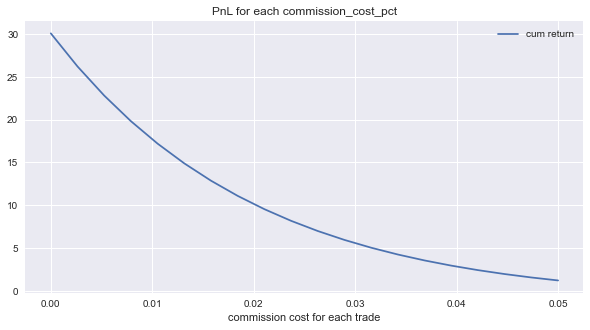

In [33]:
pair_prices = price_commodity[['Crude Oil','Gasoline']]
Y = pair_prices.iloc[:,0]
X = pair_prices.iloc[:,1]
beta, residuals, _ = OLS(Y,X)
OU_params = OU_process().fit(residuals,verbose=False).params
mu = OU_params['theta']
sigma = OU_params['sigma_eq']    

res = pd.DataFrame(columns = ['PnL','#Trade'])

for p in np.linspace(0., 0.05, 20):
    df = pairs_trading_backtesting(pair_prices, 
                                          mu = mu, sigma = sigma, 
                                          hedge_ratio = beta, 
                                          Z=1, 
                                          money_init=10000, 
                                          bet_size=1,
                                          bid_ask_spread=0.0,
                                          commission_cost_pct=p,
                                          verbose=False,
                                          plot=False)
    res.loc[p] = [df['Equity'].iloc[-1]/10000-1, df['#Trade'].iloc[-1]]
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(res['PnL'],label = 'cum return')
ax.set_title("PnL for each commission_cost_pct")
ax.set_xlabel('commission cost for each trade')
ax.legend()

# Reference:
- CQF Janaury 2022| Final Project Brief
- On the determinants of pairs trading profitability, https://www.sciencedirect.com/science/article/abs/pii/S1386418114000809

- Efficient Pair Selection for Pair-Trading Strategies
Advanced Financial Data Analysis - Patrick McSharry https://deanstreetlab.github.io/papers/papers/Statistical%20Trading/Efficient%20Pair%20Selection%20for%20Pair-Trading%20Strategies.pdf
- CQF Program| Module 6, Lecture 8: Co-Integration for Trading.

- CQF Program| Python labs: Introduction to Financial Time Series.

- CQF Program| Tutorials: Final Project Tutorial III.